In [2]:
### Imports ###
import os
import cv2
import numpy as np
from pathlib import Path
from typing import Tuple, List, Union
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
'''
Goal: resize all images to be the same dimensions while minimizing the amount of padding we have to add

Look through all of the images, get their sizes and aspect ratios, 
and then determine what resizing dimensions will require the least amount of padding
'''

def analyze_dataset_dimensions(data_dir: str, categories: List[str]) -> Tuple[float, float, List[Tuple[int, int]]]:
    dimensions = []
    aspect_ratios = []
    
    for category in categories:
        category_path = Path(data_dir) / category
        for image_path in category_path.glob('*'):
            img = cv2.imread(str(image_path))
            if img is not None:
                h, w = img.shape[:2]
                dimensions.append((h, w))
                aspect_ratios.append(h/w)
    
    aspect_ratios = np.array(aspect_ratios)
    mean_ratio = np.mean(aspect_ratios)
    std_ratio = np.std(aspect_ratios)
    
    print(f"Mean aspect ratio (h/w): {mean_ratio:.2f} ± {std_ratio:.2f}")
    print(f"Min aspect ratio: {min(aspect_ratios):.2f}")
    print(f"Max aspect ratio: {max(aspect_ratios):.2f}")
    
    print("\nSample of original dimensions (h, w):")
    for d in dimensions[:5]:
        print(d)
        
    return mean_ratio, std_ratio, dimensions

def suggest_target_size(mean_ratio: float, target_area: int = 224*224) -> Tuple[int, int]:
    """
    Suggest target dimensions maintaining mean aspect ratio with similar area to standard 224x224.
    """
    # Using the equation: h/w = ratio and h*w = area
    # Solve for w: ratio*w^2 = area
    target_w = int(np.sqrt(target_area / mean_ratio))
    target_h = int(target_w * mean_ratio)
    
    # Round to nearest multiple of 16 (common in deep learning)
    target_w = ((target_w + 8) // 16) * 16
    target_h = ((target_h + 8) // 16) * 16
    
    return target_h, target_w

data_dir = "dataset-cleaned"
categories = ["normal", "scoliosis", "spondylolisthesis"]

mean_ratio, std_ratio, dimensions = analyze_dataset_dimensions(data_dir, categories)

target_h, target_w = suggest_target_size(mean_ratio)
print(f"\nSuggested target dimensions: ({target_h}, {target_w})")

print("\nExpected padding analysis:")
total_pixels = target_h * target_w
padding_percentages = []
for h, w in dimensions:
    scale = min(target_h/h, target_w/w)
    new_h, new_w = int(h * scale), int(w * scale)
    padding_pixels = (target_h * target_w) - (new_h * new_w)
    padding_percentage = (padding_pixels / total_pixels) * 100
    padding_percentages.append(padding_percentage)

mean_padding = np.mean(padding_percentages)
print(f"Mean padding percentage: {mean_padding:.1f}%")

Mean aspect ratio (h/w): 2.97 ± 0.99
Min aspect ratio: 1.39
Max aspect ratio: 6.16

Sample of original dimensions (h, w):
(743, 217)
(918, 211)
(692, 177)
(679, 157)
(851, 234)

Suggested target dimensions: (384, 128)

Expected padding analysis:
Mean padding percentage: 23.7%


In [4]:
'''
Construct preprocessing pipeline
'''

def load_image(image_path: str) -> np.ndarray:
    """
    Load an image from 'image_path' and convert to 
    grayscale, return as numpy array
    """

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"failed to load image at {image_path}")
    
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def letterbox_resize(image: np.ndarray, target_size: Tuple[int, int]) -> np.ndarray:
    """
    Resize image to target size while maintaining aspect ratio
    """
    h,w = image.shape[:2]

    scale = min(target_size[0]/h, target_size[1]/w)
    
    new_h, new_w = int(h * scale), int(w * scale)

    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    canvas = np.zeros(target_size, dtype=resized.dtype)

    y_offset = (target_size[0] - new_h) // 2
    x_offset = (target_size[1] - new_w) // 2

    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized
    return canvas

def normalized_image(image: np.ndarray) -> np.ndarray:
    """
    normalize image values to 0-1
    """
    image = image.astype(np.float32)

    if image.max() > image.min():
        image = (image - image.min()) / (image.max() - image.min())
    
    return image

def preprocess_spine_image(image_path: str, target_size: Tuple[int, int]) -> np.ndarray:
    """
    runs full preprocessing pipeline on a single image
    """
    image = load_image(image_path)
    image = letterbox_resize(image, target_size)
    image = normalized_image(image)

    return image

def process_dataset(data_dir: str, categories: List[str], target_size: Tuple[int, int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    runs preprocessing pipeline for whole dataset
    """
    images = []
    labels = []

    for idx, category in enumerate(categories):
        category_path = Path(data_dir) / category
        for image_path in category_path.glob('*'):
            try:
                processed_image = preprocess_spine_image(str(image_path), target_size)
                images.append(processed_image)
                labels.append(idx)
            except Exception as e:
                print(f"Error processing {image_path}: {str(e)}")
    
    return np.array(images), np.array(labels)

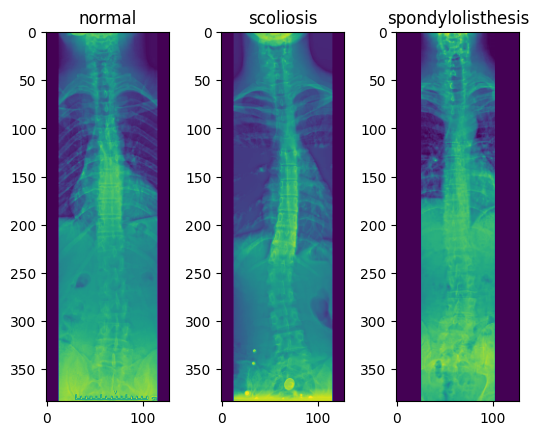

In [5]:
'''
Grab an example image and resize to 384 x 128, as determined earlier
'''

optimal_size = (384, 128)

test_normal = "dataset-cleaned/normal/N1,N,40,M_1_0.jpg"
test_scoli = "dataset-cleaned/scoliosis/N1,S,20,F_1_0.jpg"
test_spondy = "dataset-cleaned/spondylolisthesis/N2,S,N,34_1_0.jpg"

normal_processed = preprocess_spine_image(test_normal, target_size=optimal_size)
scoli_processed = preprocess_spine_image(test_scoli, target_size=optimal_size)
spondy_processed = preprocess_spine_image(test_spondy, target_size=optimal_size)

fig, axs = plt.subplots(1,3)
axs[0].imshow(normal_processed); axs[0].set_title('normal')
axs[1].imshow(scoli_processed); axs[1].set_title('scoliosis')
axs[2].imshow(spondy_processed); axs[2].set_title('spondylolisthesis')
plt.show()

As we can see, each image has the same dimensions, aspect ratios are preserved, and padding is minimal

In [6]:
''' 
Gather the pipline functions together to create a script that runs the image processing on every image and saves 
them to a directory with an appropriate title 
'''
def save_processed_image(image_array: np.ndarray, save_path: str, filename: str):
    image = Image.fromarray((image_array * 255).astype(np.uint8))
    if os.path.exists(save_path):
        image.save(os.path.join(save_path, filename))
    else:
        print(f"save path for image: {save_path}, does not exist")

def process_all_data(data_dir: str):
    """
    Creates and saves processed images into appropriate directories.
    """
    new_data_folder_path = "dataset-processed"
    os.makedirs(new_data_folder_path, exist_ok=True)

    for type_folder in os.listdir(data_dir):
        # Path for the new subdirectory to save processed images
        new_type_data_path = os.path.join(new_data_folder_path, type_folder)
        os.makedirs(new_type_data_path, exist_ok=True)  # Ensure the subdirectory exists

        subfolder_path = os.path.join(data_dir, type_folder)
        
        if os.path.isdir(subfolder_path):
            for image_file in os.listdir(subfolder_path):
                # Skip non-image files
                if not image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    continue

                image_path = os.path.join(subfolder_path, image_file)
                
                # Process the image
                img_processed = preprocess_spine_image(image_path, target_size=optimal_size)
                
                # Save the processed image
                save_processed_image(img_processed, new_type_data_path, image_file)
process_all_data("dataset-cleaned")

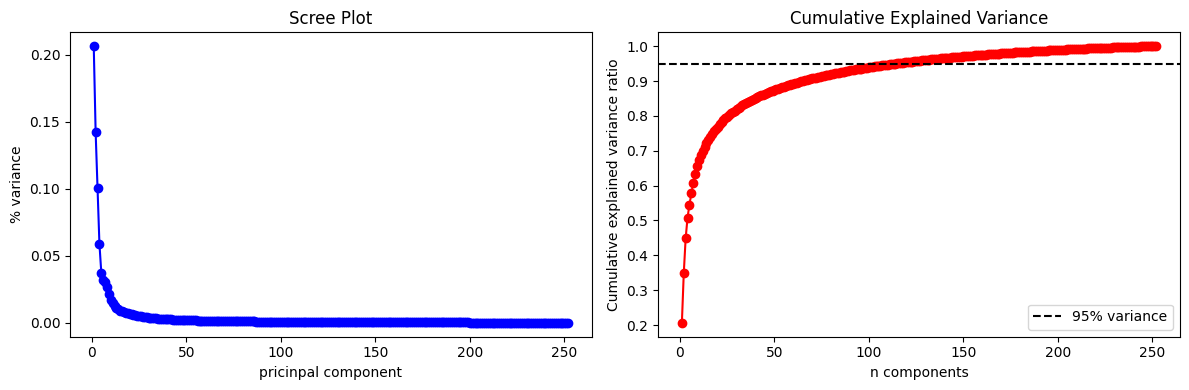

n components to explain 95% variance:  115
n components to explain 99% variance: 203
Total n components: 252

 First 10 components' explained variance:
PC1: 0.2063 (20.63%)
PC2: 0.1421 (14.21%)
PC3: 0.1007 (10.07%)
PC4: 0.0591 (5.91%)
PC5: 0.0373 (3.73%)
PC6: 0.0320 (3.20%)
PC7: 0.0301 (3.01%)
PC8: 0.0269 (2.69%)
PC9: 0.0212 (2.12%)
PC10: 0.0168 (1.68%)


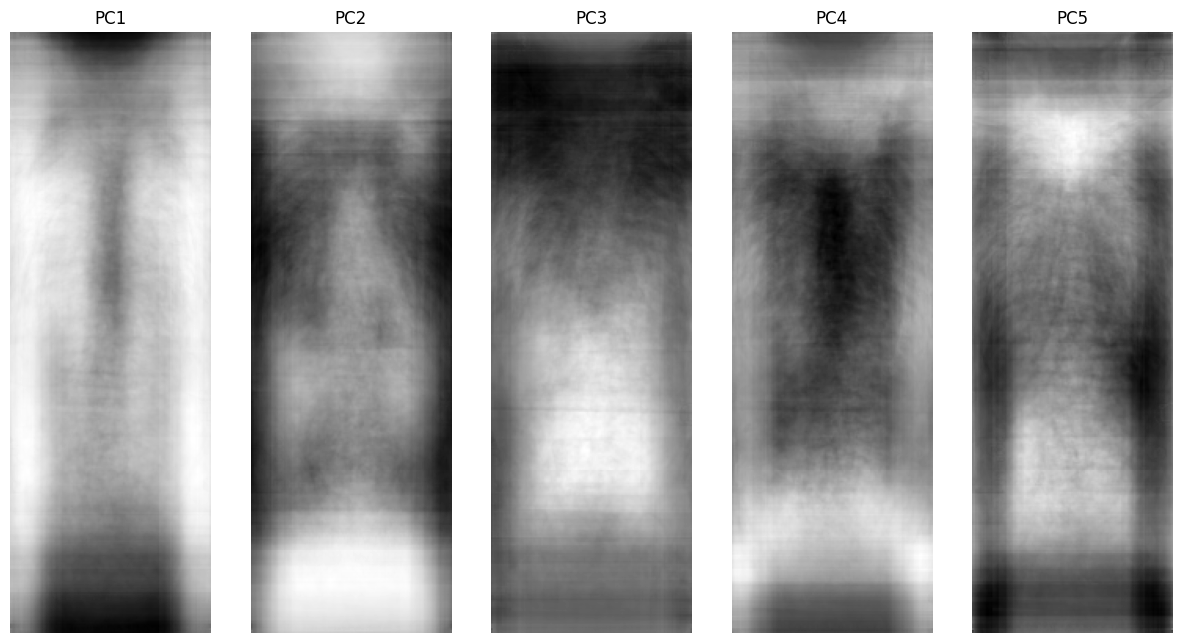

In [7]:
### PCA analysis ###
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# grab the preprocessed data
def load_processed(data_dir: str):
    images, labels = [], []
    categories = ['normal', 'scoliosis','spondylolisthesis']

    for i, c in enumerate(categories):
        path = Path(data_dir) / c
        for img_path in path.glob('*.jpg'):
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

            img_flat = img.flatten()
            images.append(img_flat)
            labels.append(c)
    
    return np.array(images), np.array(labels)

X, y = load_processed('dataset-processed')

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(Xs)

evr = pca.explained_variance_ratio_
cvr = np.cumsum(evr)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1, len(evr) + 1), evr, 'bo-')
plt.xlabel('pricinpal component')
plt.ylabel('% variance')
plt.title('Scree Plot')

plt.subplot(1,2,2)
plt.plot(range(1, len(cvr) + 1), cvr, 'ro-')
plt.xlabel('n components')
plt.ylabel('Cumulative explained variance ratio')
plt.title('Cumulative Explained Variance')
plt.axhline(y=0.95, color='k', linestyle='--', label='95% variance')
plt.legend()

plt.tight_layout()
plt.show()

n_com_95 = np.argmax(cvr >= 0.95) + 1
n_com_99 = np.argmax(cvr >= 0.99) + 1

print(f"n components to explain 95% variance:  {n_com_95}")
print(f"n components to explain 99% variance: {n_com_99}")
print(f"Total n components: {len(evr)}")

print("\n First 10 components' explained variance:")
for i, var in enumerate(evr[:10], 1):
    print(f"PC{i}: {var:.4f} ({var*100:.2f}%)")

def plot_pcs(pca, n_components=5):
    plt.figure(figsize=(15,10))
    for i in range(n_components):
        plt.subplot(1, n_components, i+1)
        component = pca.components_[i].reshape(384, 128)
        plt.imshow(component, cmap='gray')
        plt.title(f'PC{i+1}')
        plt.axis('off')
    plt.show()

plot_pcs(pca)

In [8]:
### Now, project all the data onto the first 3 PCs, plot in 3D ###
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd


X, y = load_processed('dataset-processed')

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for plotly
df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'PC3': X_pca[:, 2],
    'Category': y
})

# Create interactive 3D scatter plot
fig = px.scatter_3d(
    df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Category',
    title='3D PCA of Spine X-rays',
    labels={
        'PC1': f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)',
        'PC2': f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)',
        'PC3': f'PC3 ({pca.explained_variance_ratio_[2]:.2%} variance)'
    }
)

# Update layout for better visualization
fig.update_traces(marker=dict(size=5))
fig.update_layout(
    title_x=0.5,
    scene=dict(
        xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]:.2%})',
        yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]:.2%})',
        zaxis_title=f'PC3 ({pca.explained_variance_ratio_[2]:.2%})'
    )
)

fig.show()